# Mann-Whitney comparisons of Spenser verse and decadal verse

In [1]:
# Dec. 10, 2019 dk

There are several major sections in this notebook:

1) [Set-up code](#1.-Load-data) and data manipulation that can be skipped over when reading. 

2) An [introduction to Mann-Whitney](#2.-Introduction-to-Mann-Whitney-calculations) calculations, how to read them, and how they are calculated, including a contrived example,

3) Several explorations of a comparison of all of [Spenser with the 1560s](#3.-Back-to-real-examples) corpus, in order to discover some strengths and weaknesses of Mann-Whitney,

4) Comparisons of [all of Spenser with a constructed verse corpus for each decade](#4.-Using-Mann-Whitney-calculations%2C-compare-all-of-Spenser-with-the-verse-of-each-decade%2C-1560s-1590s) from the 1560s through the 1590s,

5) Comparisons of [each decade with each other decade](#5.-Compare-decades-with-each-other), and

6) Comparisons of [each decade with an aggregate of the subset of Spenser works](#6.-Finally%2C-compare-decades-with-contemporaneous-Spenser-works) properly dated to that decade.


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline

In [3]:
import multiprocessing
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default

## 1. Load data

In [4]:
# Load term-doc-count frame
#   -- if it doesn't already exist, and "versetokencounts.tsv.gz" does exist, 
#   uncomment the commented "load_df" lines in the cell below. 

df = pd.read_csv("versetokenpivot.csv.gz", index_col=0)

In [5]:
def load_df():
    tokencounts = pd.read_csv("versetokencounts.tsv.gz", sep="\t", header=None)
    tokencounts.columns = ["tcpid","token","count"]
    tokencounts['token'] = tokencounts['token'].map(lambda x: str(x).lower())
    tokencounts = tokencounts.groupby(['tcpid','token']).sum().reset_index()
    piv = tokencounts.pivot_table(index="tcpid", columns="token", values="count").fillna(0)
    df = piv.T
    del(tokencounts)
    del(piv)
    return df

# load_df()
# df.to_csv("versetokenpivot.csv.gz")

## Load metadata and organize subcorpus ids

In [6]:
metatmp = pd.read_csv("EEBO_metadata.tsv", sep="\t", header=None, index_col=0).drop_duplicates()
metatmp.columns = ['year','author','title','s1','s2','phase']
del(metatmp['s2'])
meta = metatmp.to_dict(orient="index")

In [7]:
allspenserids = list(metatmp[metatmp['author'].map(lambda x: 
                                                x.startswith("Spenser, Ed"))].index[2:]) + ['A08269']
spenserids = [s for s in allspenserids if s in df.columns]

In [8]:
decade = {}
decade[1560] = [k for k in meta.keys() if meta[k]['year'] >= '1560' and meta[k]['year'] < '1570' and k in df.columns]
decade[1570] = [k for k in meta.keys() if meta[k]['year'] >= '1570' and meta[k]['year'] < '1580' and k in df.columns ]
decade[1580] = [k for k in meta.keys() if meta[k]['year'] >= '1580' and meta[k]['year'] < '1590' and k in df.columns]
decade[1590] = [k for k in meta.keys() if meta[k]['year'] >= '1590' and meta[k]['year'] < '1600' and k in df.columns ]

In [9]:
doctotals = df.sum()
relf = df/doctotals

## Define utility functions

In [10]:
def calcmw(pair):
    series1, series2 = pair
    term = series1[0]
    r = mannwhitneyu(series1[1], series2[1], alternative="two-sided")
    return (term, r[0], r[1])

In [11]:
def comparemw(df1, df2):
    pool = multiprocessing.Pool(processes=cpus-1)
    seq = zip(df1.iterrows(), df2.iterrows())
    results = pool.map(calcmw, seq)
    pool.close()
    pool.join()
    mw = pd.DataFrame(results, columns=['term','U','pvalue'])
    n1n2 = df1.shape[1] * df2.shape[1]
    mw['rho'] = mw['U'] / n1n2
    return mw

In [12]:
def mwshow(lframe, rows=10):
    """Given a dataframe of the sort returned by `llhd`, 
    show two side-by-side HTML renderings of the top N rows (10 by default), 
    sorted respectively by the log-likelihoods of the first and the second columns."""
    html = lframe.sort_values(by="rho", ascending=False).head(rows).to_html(index=False) + \
        lframe.sort_values(by="rho").head(rows).to_html(index=False)
    display(HTML(html.replace("<table ", "<table style='display:inline;margin:0 5em 0 0;'")))

In [13]:
def compare_by_ids(ids1, ids2, mincount=3, raw=False):
    if raw == True:
        ldf = df
    else:
        ldf = relf
    subframe = df[ids1 + ids2]
    subterms = subframe[subframe.sum(axis=1) >= mincount].index.dropna().values
    subterms = [s for s in subterms if '•' not in s]
    df1 = ldf.loc[subterms, ids1]
    df2 = ldf.loc[subterms, ids2]
    mw = comparemw(df1, df2)
    return mw

In [14]:
def showterm(term, ids1, ids2, labels=['spenser','reference'], raw=False):
    if raw == True:
        ldf = df
    else:
        ldf = relf
    docs = ldf.loc[[term], ids1].T
    docs.columns.name = 'docid'
    docs['corpus'] = labels[0]
    tmp = ldf.loc[[term], [d for d in ids2 if d not in ids1]].T
    tmp.columns.name = 'docid'
    tmp['corpus'] = labels[1]
    docs = docs.append(tmp)
    docs = docs.sort_values(by=term, ascending=False)
    docs_nz = docs.query(f"{term} > 0").copy().reset_index()
    plt.figure(figsize=(20,2))
    target = docs_nz.query(f"corpus=='{labels[0]}'")
    reference = docs_nz.query(f"corpus!='{labels[0]}'")
    if len(target.index) > 0:
        _ = plt.bar(target.index, target[term], color='red', label=labels[0])
    if len(reference.index) > 0:
        _ = plt.bar(reference.index, reference[term], color='#44AA22', label=f'{labels[1]}')
    plt.title(f"'{term}' in {labels[0]} and {labels[1]}")
    _ = plt.legend()

## 2. Introduction to Mann-Whitney calculations

Mann-Whitney gives us a way to compare the words in two corpora by comparing the rankings of words in the documents of both corpora.

As Ted Underwood [reported](https://tedunderwood.com/2011/11/09/identifying-the-terms-that-characterize-an-author-or-genre-why-dunnings-may-not-be-the-best-method/) back in 2011, Mann-Whitney overcomes a problem with using Dunning's log-likelihood, which pools all the documents in each subcorpus, so that a high concentration of a word in a small number of documents can have a disproportionate effect when we measure relative frequencies of that word across the all documents of its subcorpus. 

With Mann-Whitney, we respect the independent boundaries of each document within each subcorpus. For a given term, we rank all the documents in order across both subcorpora, and then we measure how mixed the subcorpora are. For example, if every Spenser document outranks every other contemporary document in the presence of a particular word, or vice versa, that would be interesting to know. If the ranks are mixed, as often will be, we would like to fix a number that would characterize how much the rankings favor one collection or the other. 

In this notebook I will generally use relative frequencies (the count of a given word divided by document length) to establish rankings, although there will be some examples calculating both ways to see what can change.

Mann-Whitney throws away some information about the concentration of terms. Once a document ranks \#1 for a particular term, we could imagine increasing the count of that term in that document even further, and it wouldn't affect the Mann-Whitney calculation. Nevertheless, it takes into account more document-level distributional information than TF-IDF or log-likelihood calculations do.

### Preview of Mann-Whitney comparisons

Here's an example of some Mann-Whitney scores comparing documents in all of Spenser and documents in a subcorpus of 1560s verse. We'll do some systematic comparisons like this below, but the first task is to establish what we're going to be looking at.

In [15]:
mw = compare_by_ids(spenserids, decade[1560])
mwshow(mw)

The frame at the left shows words that pull in the direction of Spenser over the 1560s verse subcorpus, and the frame at the right shows the reverse.

The `U` statistic is the primary result of a Mann-Whitney calculation, and sorting by that number or by `rho` accomplishes the same thing. The U statistic is calculated not by comparing raw frequencies across documents and subcollections, but by ranking all the documents and comparing which of our two subcollections, if any, the relative rankings favor. Although generally we don't need to think too much about what the precise values of U mean, there will be a contrived example below that offers one way to understand them intuitively. The Wikipedia article on [Mann-Whitney](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) offers examples with another approach.

The `p-value` is part of the machinery of traditional null-hypothesis-significance-testing. Larger decimals mean "don't get too impressed," but we often also shouldn't be excessively impressed by the smaller fractions, either. We are not going try to consider the statistical assumptions that would be necessary to make p-values meaningful. We already know that language isn't random, but larger decimals tell us that if it were, there would be a better chance of seeing this pattern randomly than there would be with a smaller decimal.

The most useful and intuitive number to look at here is **`rho`**, which is just a rescaling of the U statistic so that all values are between 0 and 1. We can think of it as a gauge that indicates a word leans fully toward one subcorpus when it's 0, fully toward the other subcorpus when it's 1.0, and it reports an even mixing of subcorpora when it's around 0.5.

The frame above suggests that "goodly," "world's," "cheerful," "flower," etc. may be particularly Spenserian terms relative to English verse in the 1560s. 

Below we will return to the question: what does "particularly Spenserian" mean concretely in this case?

But first, let's work a brief example to understand exactly where the `U statistic` and `rho` are coming from.

### Contrived example

As a contrived example small enough to visualize relatively easily, let's look at 12 Spenser documents and compare them to 20 randomly selected documents from the 1560s verse, and let's calculate the Mann-Whitney scores for just one word. There's no special interpretive insight to be expected here; we just want to see how the calculations work. The set-up code here is particularly ignorable.

In [16]:
import random
random.seed(10)
otherids = random.sample(list(doctotals[decade[1560]].sort_values(ascending=False).index), 20)

In [17]:
term = "fresh"
sframe = relf.loc[[term],spenserids].T.reset_index()
rframe = relf.loc[[term],otherids].T.reset_index()
sframe.columns = ['docid','relfreq']
rframe.columns = ['docid','relfreq']
sframe['term'] = term
rframe['term'] = term
cframe = sframe.merge(rframe, how="outer", left_on="term", right_on="term", suffixes=['_spenser','_other'])
cframe['score'] = 0.5
cframe.loc[cframe['relfreq_spenser'] > cframe['relfreq_other'], 'score'] = 1
cframe.loc[cframe['relfreq_spenser'] < cframe['relfreq_other'], 'score'] = 0
cframe = cframe[['term','docid_spenser','relfreq_spenser','docid_other','relfreq_other','score']]
rect = cframe.pivot_table(columns="docid_other", index="docid_spenser", values="score")

Let's look at the word **fresh** in these two sets of documents. Here are the documents from both collections, ranked by relative frequency, ignoring those with zero counts (although they will eventually matter to the calculation):

In [18]:
showterm("fresh", spenserids, otherids, labels=["Spenser", "other"])

And here are the relative frequencies of the term in each document, with Spenser documents on the left, and the other documents on the right:

In [19]:
html =  sframe[['docid','relfreq']].sort_values(by="relfreq", ascending=False).to_html(index=False) + \
    rframe[['docid','relfreq']].sort_values(by="relfreq", ascending=False).to_html(index=False)
HTML(html.replace("<table ", "<table style='display:inline;margin:0 5em 0 0;'"))

The top two documents, and three of the top four, are from the "other" group. So far this evidence favors the right-hand collection as more interesting with respect to the word "fresh."

However, the relative frequencies on the right-hand side fall off fast and drop to zero after six documents out of twenty, while all but two of twelve Spenser documents on the left have some presence of the word "fresh". 

To calculate the Mann-Whitney U statistic, we could think of this as $12 × 20 = 240$ separate pairwise contests of each Spenser document against each of the right-hand documents. In every contest if the left-hand team wins, the score is 1, if the right-hand team wins, the score is 0, and if it's a tie, the score is 0.5. We don't care *by how much* any given contest is won. Document A06860 already wins 12 contests, one against every Spenser document, and if its relative frequencies were ten times larger, the results wouldn't change; it will still win just 12 of 12 possible contests.

The first Spenser document, A12781, loses to two of the other documents, and beats the other 18.

The second Spenser document, A08269, loses to three of the other documents, and beats the other 17.

The U statistic is the total number of contests that the Spenser side wins in all pairings of documents from both sides. 

In this case `U` ends up being 185. Since there are 240 contests altogether, that means the Spenser team wins $77.1 \%$ of them $(185/240)$. That's `rho`.

In [20]:
U = rect.sum().sum()
rho = U / 240
print(f"U: {U}      rho: {rho:0.1%}")

U: 185.0      rho: 77.1%


The following visualization would not be practical with a larger example, but for the sake of intuition we can visualize the contests as a matrix of match-ups. The green squares represent a win for Spenser and count as 1, and the gray squares are ties, which count as 0.5. The rest are 0. Altogether that amounts to 185, or 77% of the grid. The vertical white bands show the three documents from the right-hand side that have higher relative frequencies than most of the Spenser documents. The gray squares at the bottom show documents that are tied because they are zeros on both sides. 

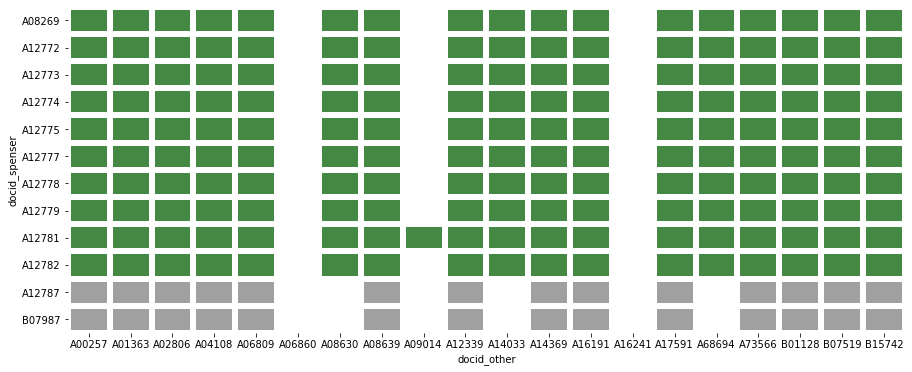

In [21]:
plt.figure(figsize=(15, 6))
_ = sns.heatmap(rect, cbar=False, cmap=['white','#A0A0A0','#448844'], linewidths=5)

If we compared 100 documents against 200 documents, we would have 20,000 rank comparisons, and so many U numbers would necessarily be larger. That's why it's easier to make sense of `rho`, which is always scaled between 0 and 1, regardless of how many documents we are comparing on either side.

## 3. Back to real examples

Here again is our less-contrived example of Mann-Whitney scores, where we are comparing documents in all of Spenser with documents in a subcorpus of 1560s verse:

In [22]:
mw = compare_by_ids(spenserids, decade[1560])
mwshow(mw)

The frame above suggests that "goodly," "world's," "cheerful," "flower," etc. are particularly Spenserian terms relative to the verse in the 1560s.

What does "particularly Spenserian" mean concretely in this case?

In [23]:
showterm("goodly", spenserids, decade[1560], labels=["Spenser", "1560s verse"])

In the chart above, each bar is a document; the red bars are Spenser texts from EEBO-TCP, and the green bars are documents of verse extracted from TCP texts from the 1560s. The vertical scale indicates the relative frequency of the word "goodly" in each text, and the bars are obviously ranked in descending order. If all the red bars were to the left of all the green bars, the Mann-Whitney score would be 1.0. If the bars alternated consistently between red and green, the score would be near 0.5. If all the green bars were to the left, and all the red to the right, the score would be 0. 

Although the bar graph doesn't show this, Mann-Whitney takes into account any zero-count documents, so you can imagine zero-height red bars and green bars off to the right, each of which either loses all its pairwise contest, or ties when it's matched with other zero-count documents.

In this case, a score of 0.92 for "goodly" is a way of saying that when we rank all the documents we're comparing in this way, Spenser documents tend to come out ahead of the other documents. No single document is sufficient to determine this score. If the first document had a concentration higher than all other documents combined, nothing would change. In fact, any of the bars could move up and down on the vertical scale — let's say we make the first five bars ten times higher than they are now, and the rest each one-tenth as high as they are now — and as long as they keep their relative ranking, the Mann-Whitney score would be unchanged. This can be a strength rather than a weakness, insofar as we want support for a claim like "Spenser uses the word 'goodly' across his various poetic works demonstrably more than was common in poetic works of the 1560s."

What we get out of Mann-Whitney depends on how we decide to rank texts. We can use raw counts, but there are big differences between small and large texts in our corpus. We can divide by text length to get relative frequencies, but that doesn't remove the effect of differences in text length; it will instead tend to privilege short texts over long ones, because the smallest possible relative frequency in a short text can be much higher than common relative frequencies in a long text.

Mann-Whitney also isn't so helpful when we have just one document in one of the subcorpora, for reasons that are perhaps obvious: the ranking of that one document is all the evidence we have, and wherever it lands is all the mixing we can get. The imagined contest grid is just a $1 × N$ rectangle.

For example, if we compare just the *Theatre* to the 1560s verse:

In [24]:
theatre = ['A08269']
verse1560 = [i for i in decade[1560] if i not in spenserids]
mwshow(compare_by_ids(theatre, verse1560))

There are many terms that have a rho value of 1.0, which just means that the single document of the *Theatre* ranks more highly for those terms than any other document in the 1560s verse corpus does. Here's "breathe":

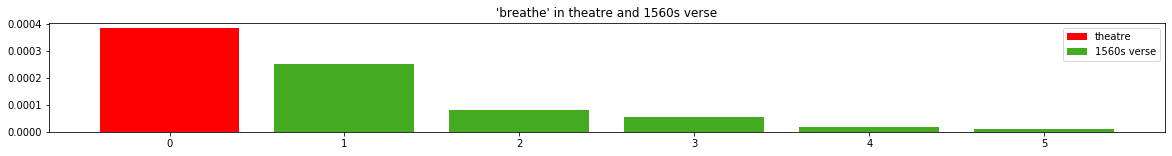

In [25]:
showterm("breathe", theatre, verse1560, labels=['theatre','1560s verse'])

"breathe" is just one of 143 words where the *Theatre* ranks first. A rho of 1.0 can result from a pattern like "priesthood," which appears just twice in the *Theatre* verse and once in Skelton's *Works* (1568):

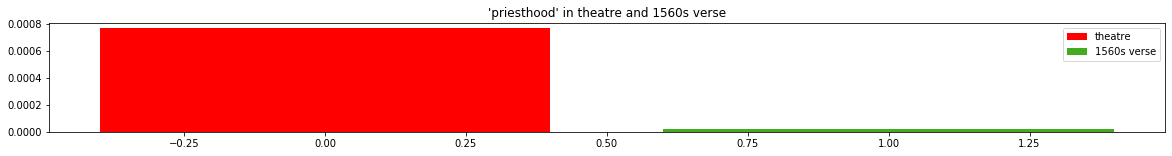

In [26]:
showterm("priesthood", theatre, verse1560, labels=['theatre','1560s verse'])

Note I've been calculating rankings based on relative frequencies. 

There's much more of Skelton's verse than there is verse in the *Theatre*, and under relative frequencies, the word "chanting" looks much like the word "priesthood," although by raw counts it turns out it's the reverse -- two instances in Skelton, one in *Theatre*:

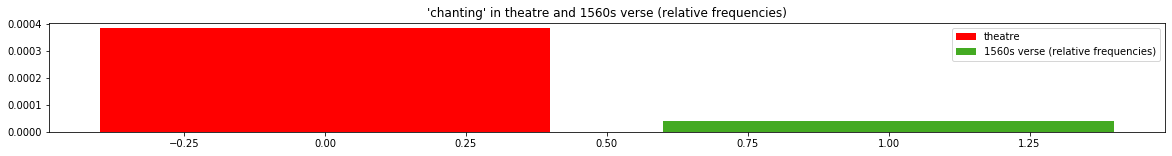

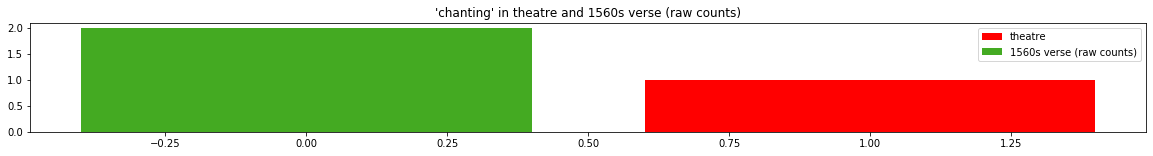

In [27]:
showterm("chanting", theatre, verse1560, labels=['theatre','1560s verse (relative frequencies)'])
showterm("chanting", theatre, verse1560, labels=['theatre','1560s verse (raw counts)'], raw=True)

One point of this is to see that with such small counts, we might deceive ourselves if we concluded too quickly that our Mann-Whitney arithmetical machinery is actually telling us much when it reports that the needle points all the way to either 1 or 0.

A rho of 1.0 can also result from a pattern like "shining" or "cloud," which appear in dozens of other texts. Words like these might turn out to be more interesting to pursue (although differences in document length may yet make these patterns less informative and less interesting than they first appear):

In [28]:
showterm("shining", theatre, verse1560, labels=['theatre','1560s verse'])
showterm("cloud", theatre, verse1560, labels=['theatre','1560s verse'])

These bar charts are not intrinsic to Mann-Whitney calculations. They are intended to help develop intuitions about the machinery behind Mann-Whitney, and its possible uses and limitations; they show us what Mann-Whitney draws from, obscures, and reduces to a number. If all we have is the number, we get some information that constrains what possible bar charts could look like, but not enough to reconstruct the distribution.

### Relative frequencies versus raw counts 

Let's look once more at all of Spenser versus 1560s verse, using relative frequencies:

In [29]:
mwshow(compare_by_ids(spenserids, decade[1560]))

Here's a list using raw counts to calculate Mann-Whitney instead:

In [30]:
mwshow(compare_by_ids(spenserids, decade[1560], raw=True))

On the one (left) hand, it's reassuring that the list of Spenser-associated words doesn't change *too* much whether we use raw counts or relative frequencies.

The right-hand list of not-so-Spenserian words has changed completely, but those high p-values and closer-to-5.0 rho values tell us not to read too much into them. Here's the distribution of "shall" as a not-so Spenserian word when ranked by relative frequencies, and a comparison to help us see why raw counts would move its score toward the middle. "Shall" is a common enough word that it can appear in lots of short documents, and so it's easy for a lot of documents to have relative frequencies of "shall" higher than many of Spenser's documents. That doesn't mean he doesn't use the word "shall" frequently in absolute terms; he does.

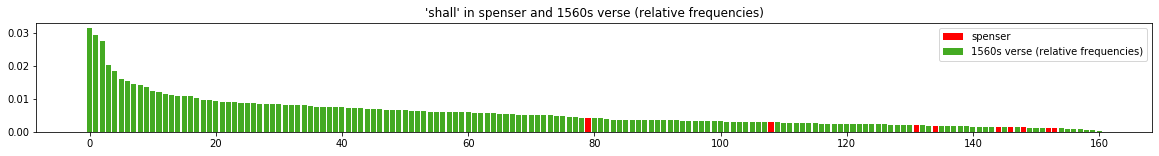

In [31]:
showterm("shall", spenserids, decade[1560], raw=False, labels=['spenser','1560s verse (relative frequencies)'])
showterm("shall", spenserids, decade[1560], raw=True, labels=['spenser','1560s verse (raw counts)'])

Back on the left-hand side of our comparison lists, why does "cheerful" show up when we use raw counts, but not show up near the top of the list when we rank by relative frequency?

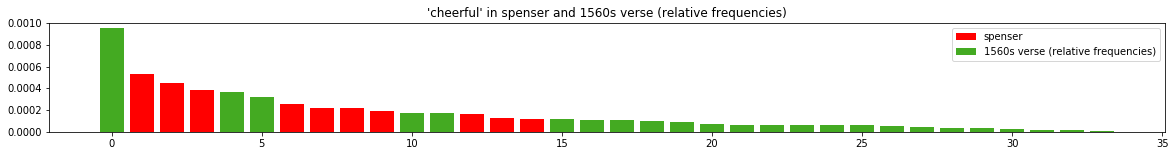

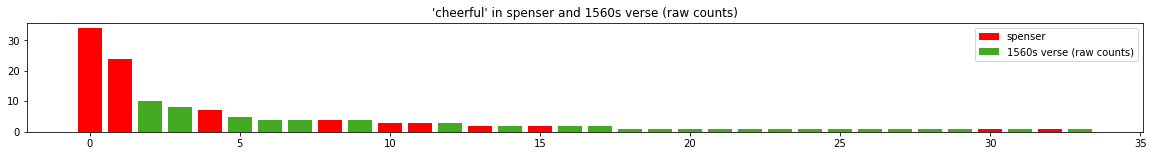

In [32]:
showterm("cheerful", spenserids, decade[1560], raw=False, labels=['spenser','1560s verse (relative frequencies)'])
showterm("cheerful", spenserids, decade[1560], raw=True, labels=['spenser','1560s verse (raw counts)'])

The *relatively* most "cheerful" verse document is the Thomas Churchyard's *Lamentacion of Freyndshyp*, which has a high ratio with one instance of "cheerful" amid 1,050 words.

The *absolutely* most "cheerful" verse in the 1560s is Arthur Golding's translation of Ovid's *Metamorphosis*, with 10 instances, which is fewer than the 24 and 34 instances in the 1590 and 1596 volumes, respectively, of the *Faerie Queene.*

Relative frequencies by no means justify forgetting that texts are of different lengths, and text length matters. Words do not flow like liquid within and among documents. We can't simply divide to make everything commensurable and be done with it. We can of course divide and see what happens, try all our options, and keep thinking and learning, knowing that it may take some imaginative effort to piece together a better understanding of the relation between what we are looking *at* and what we are looking *for.*

**Taking all these caveats on board,** it's still interesting that **goodly** shows up as a Spenser-leaning word on both the relative-frequency and the raw-count lists. And in fact "goodly" is going to turn out to remain the top word consistently when we compare Spenser to each decade subcorpus through the 1590s. Before we look at the Mann-Whitney lists, here are the distributional patterns for "goodly" across decades, first by raw counts, and then by relative frequencies:

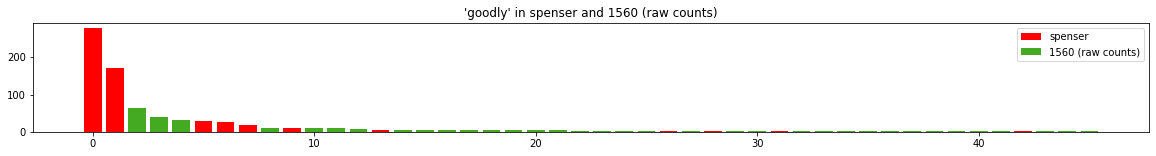

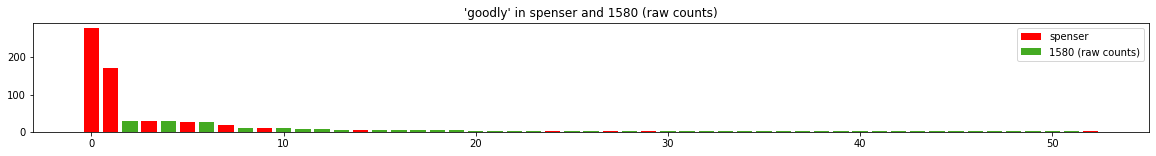

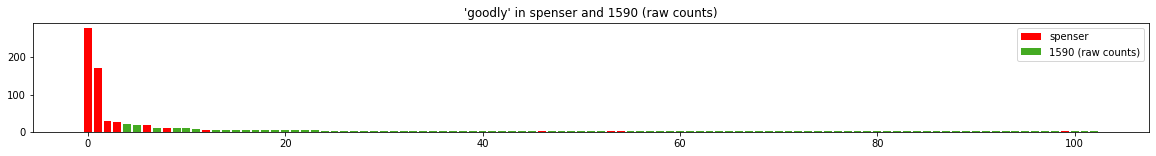

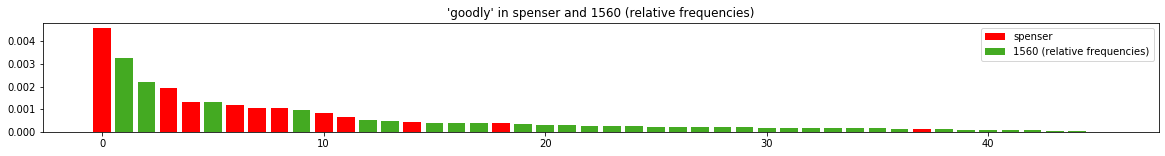

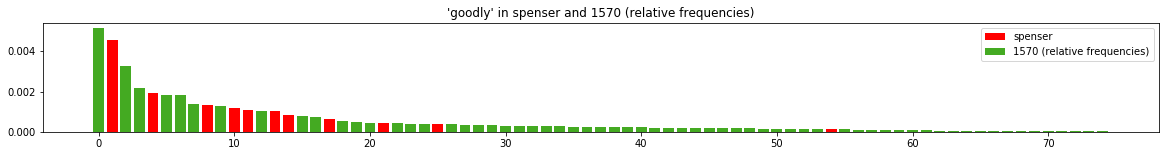

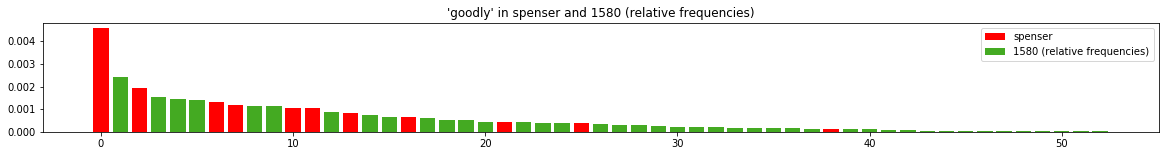

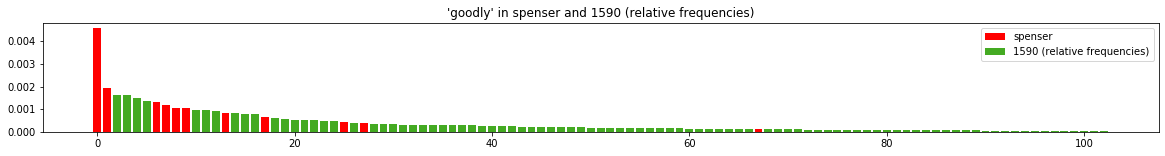

In [33]:
for raw in [True, False]:
    for dec in range(1560, 1600, 10):
        showterm("goodly", spenserids, decade[dec], raw=raw, 
                 labels=['spenser', str(dec) + (raw and " (raw counts)" or " (relative frequencies)")])

Despite the fact that relative frequencies give disproportionate weight to word distributions in smaller documents, we can see that the two volumes of the *Faerie Queene* will have a considerable effect on ranking scores if we use raw counts. In what follows we'll stick with relative frequencies by default, but keep in mind that we may be missing some "cheerful" possibilities of absolute counts.

## 4. Using Mann-Whitney calculations, compare all of Spenser with the verse of each decade, 1560s-1590s

We have spent a lot of time using Spenser vs. 1560 as an example; we'll now look at similar Mann-Whitney scores for subsequent decades.

In [34]:
mwshow(compare_by_ids(spenserids, decade[1570]))

In [35]:
mwshow(compare_by_ids(spenserids, decade[1580]))

In [36]:
mwshow(compare_by_ids(spenserids, decade[1590]))

## 5. Compare decades with each other

In [37]:
mwshow(compare_by_ids(decade[1560], decade[1570]))

In [38]:
mwshow(compare_by_ids(decade[1560], decade[1570], raw=True))

In [39]:
mwshow(compare_by_ids(decade[1560], decade[1580]))

In [40]:
mwshow(compare_by_ids(decade[1560], decade[1590]))

In [41]:
mwshow(compare_by_ids(decade[1570], decade[1580]))

In [42]:
mwshow(compare_by_ids(decade[1570], decade[1590]))

In [43]:
mwshow(compare_by_ids(decade[1580], decade[1590]))

## 6. Finally, compare decades with contemporaneous Spenser works

We saw a version of this already as an example, above. Here we'll try to make the results a little more interesting by removing words that don't appear at least 10 times altogether across the texts of interest. Then we'll look at some rank distributions for various words, not all selected from the top 10 by the Mann-Whitney calculations shown.

In [58]:
theatre = ['A08269']
verse1560 = [i for i in decade[1560] if i not in spenserids]
mwshow(compare_by_ids(theatre, verse1560, mincount=20))

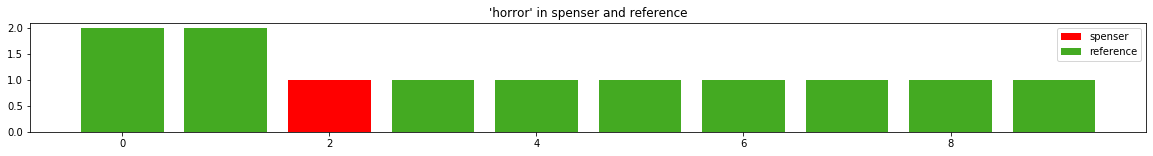

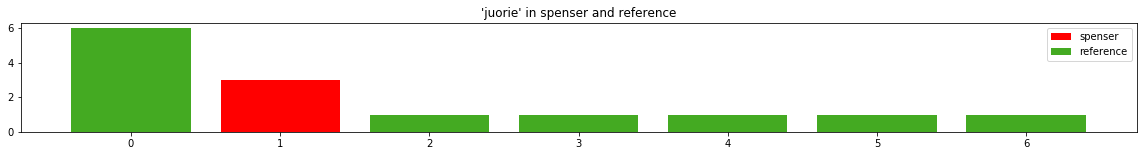

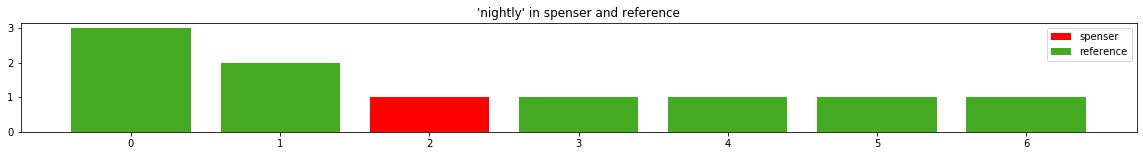

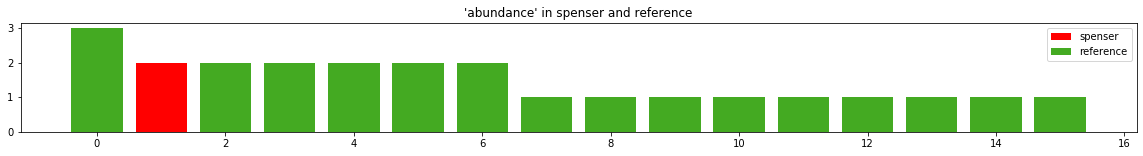

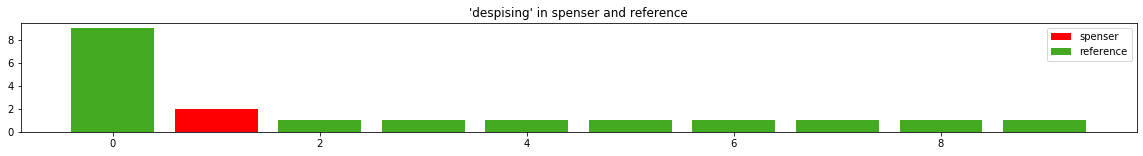

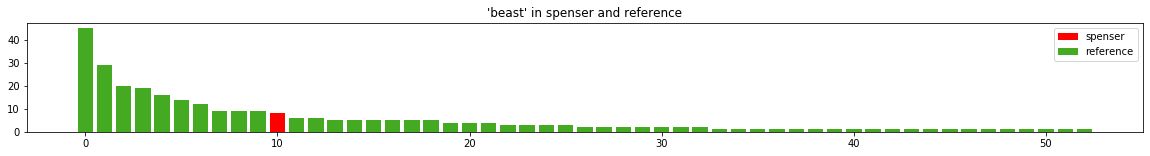

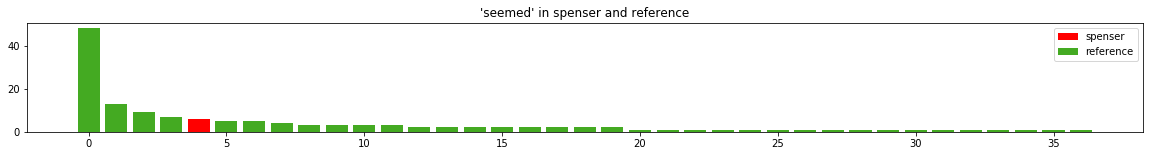

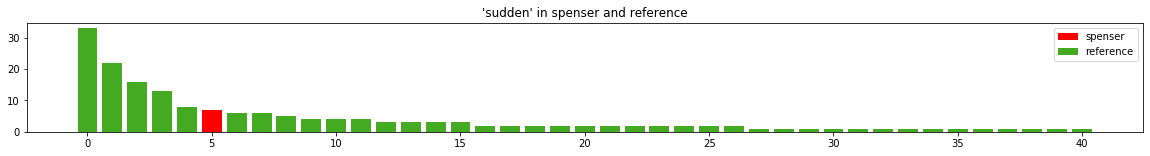

In [62]:
_ = [showterm(term, theatre, verse1560, raw=True) for term in 
     ['horror','juorie','nightly','abundance','despising','beast','seemed','sudden','tree', 'bottom','raised']]

In [46]:
calender = ['A12782']
verse1570 = [i for i in decade[1570] if i not in spenserids]
mwshow(compare_by_ids(calender, verse1570, mincount=10))

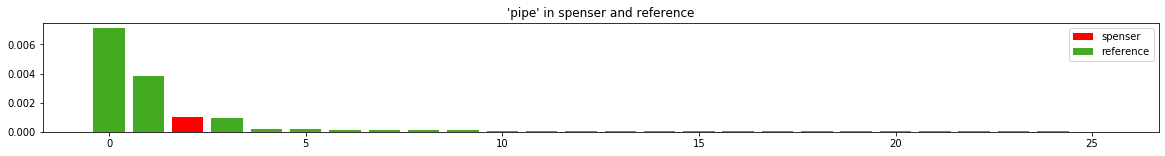

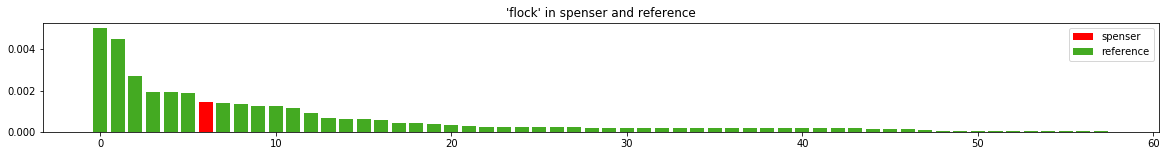

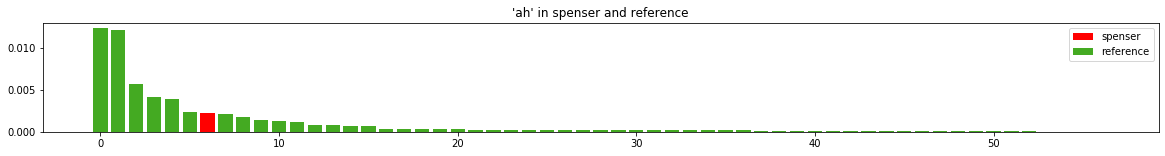

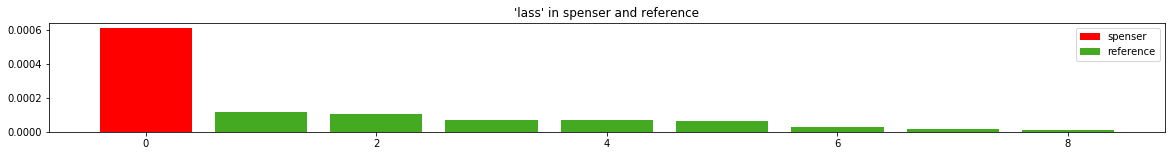

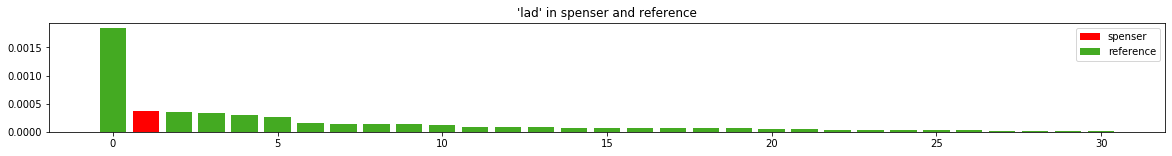

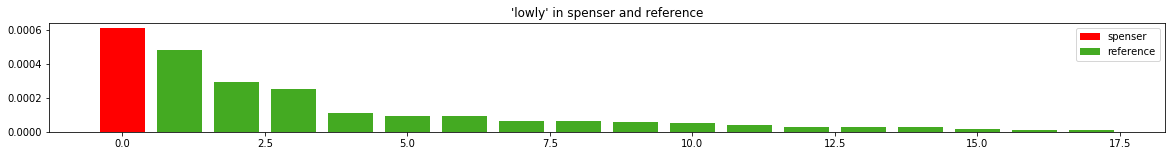

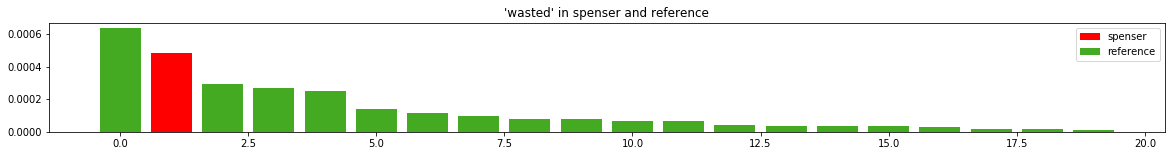

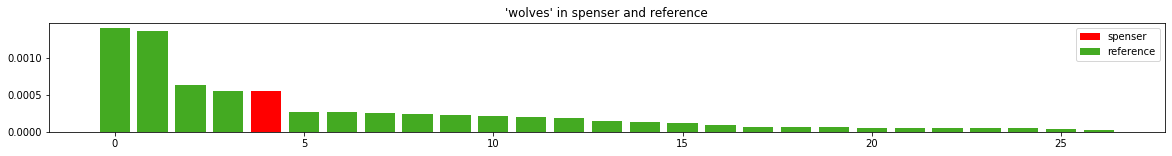

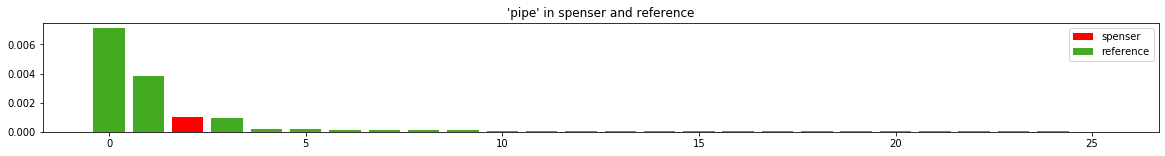

In [47]:
_ = [showterm(term, calender, verse1570, raw=False) for term in 
     ['shepherd','shepherds','pipe','flock','ah','whilom','lass','lad','lowly','wasted', 'wolves','pipe']]

In [48]:
letters = ['A12787']
verse1580 = [i for i in decade[1580] if i not in spenserids]
mwshow(compare_by_ids(letters, verse1580, mincount=10))

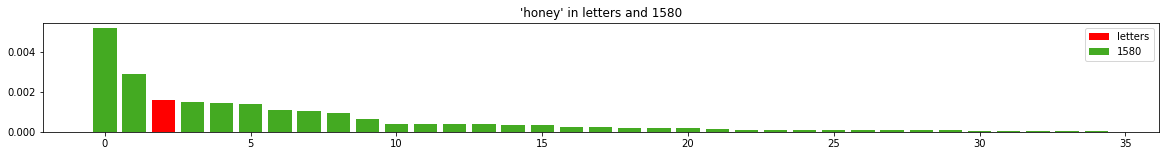

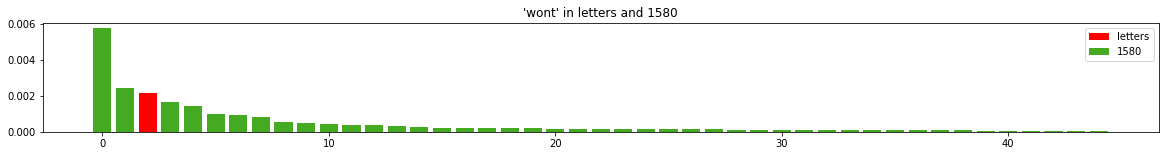

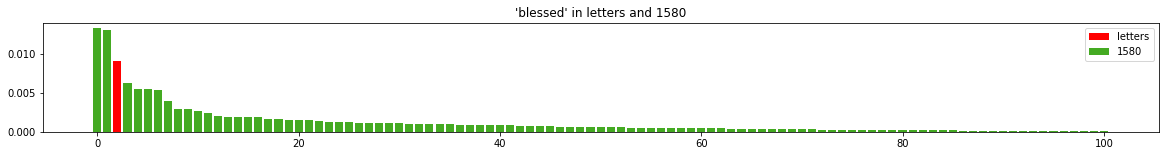

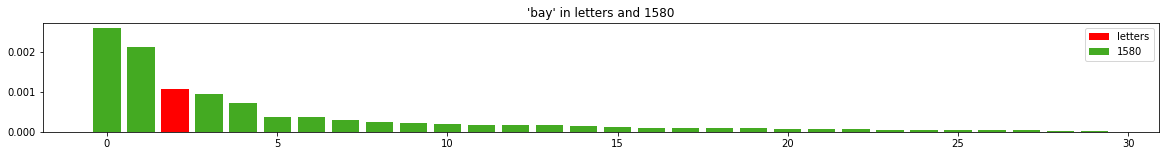

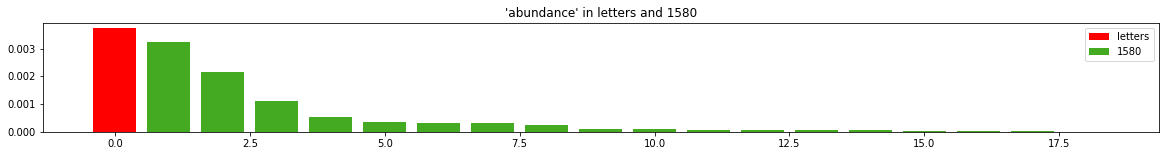

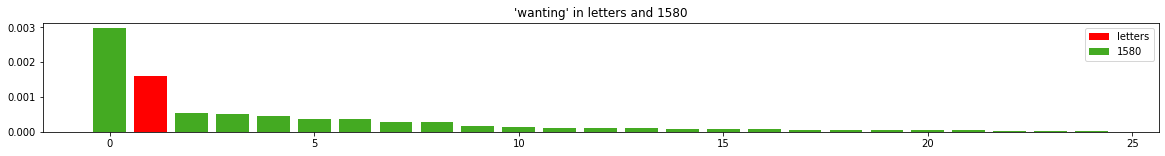

In [49]:
_ = [showterm(term, letters, verse1580, raw=False, labels=["letters", "1580"])   
     for term in ["honey","wont","blessed","bay",'abundance','wanting']]

In [50]:
spenser1590s = [i for i in decade[1590] if i in spenserids]
verse1590 = [i for i in decade[1590] if i not in spenserids]
mwshow(compare_by_ids(spenser1590s, verse1590, mincount=10), rows=30)

In the charts below, the top couple of documents often are not Spenser, but that may be because the documents are short, and therefore can have high relative frequencies.

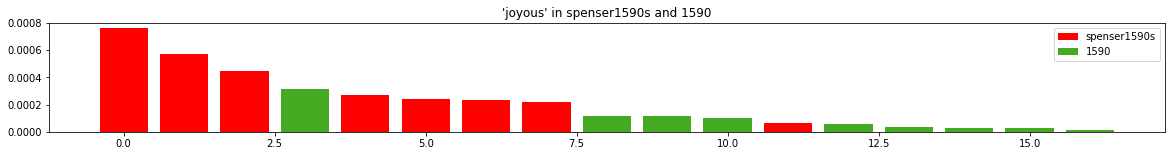

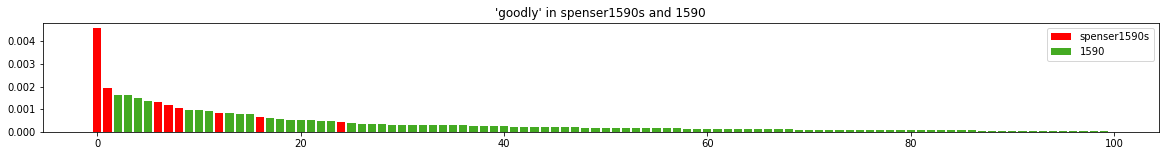

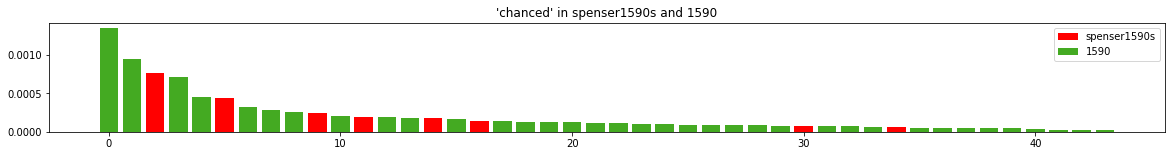

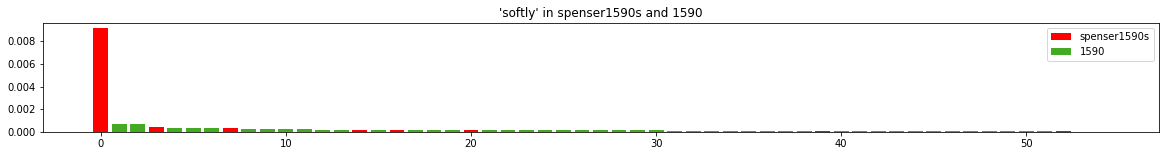

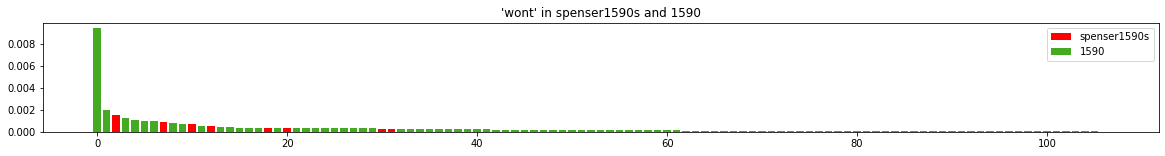

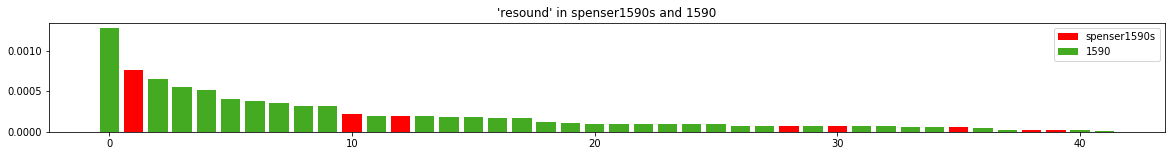

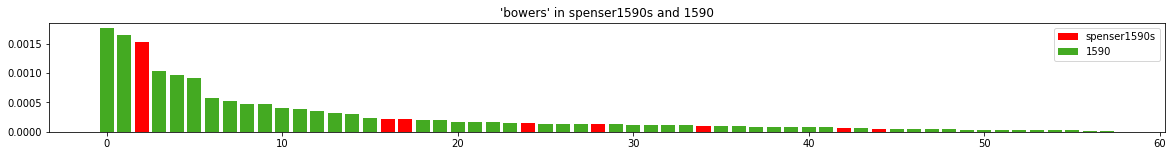

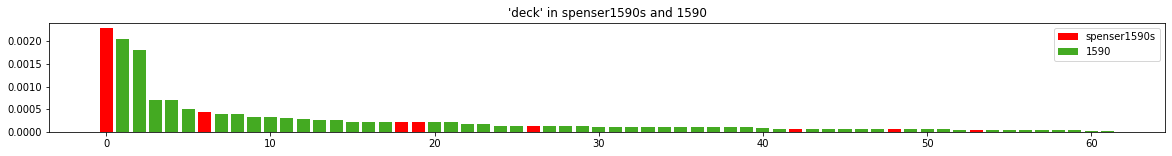

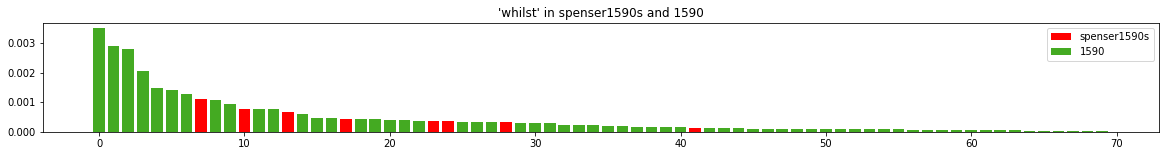

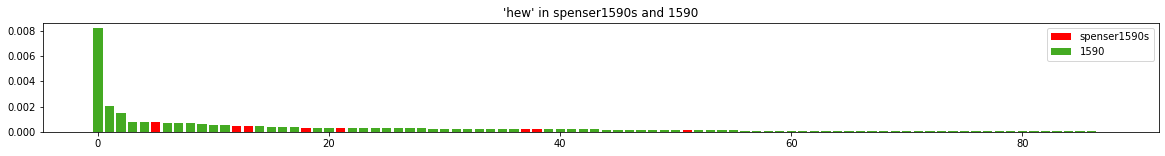

In [51]:
_ = [showterm(term, spenser1590s, verse1590, raw=False, labels=["spenser1590s", "1590"])   
     for term in ["joyous","goodly","chanced","softly",'wont','resound','bowers','deck','whilst','hew']]

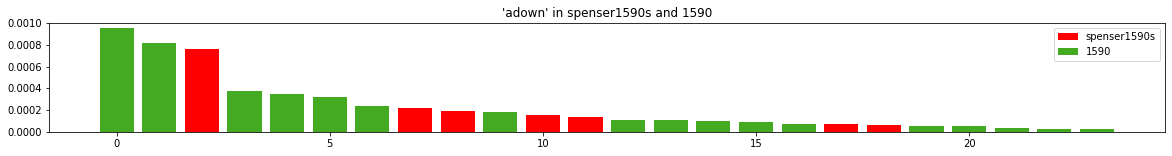

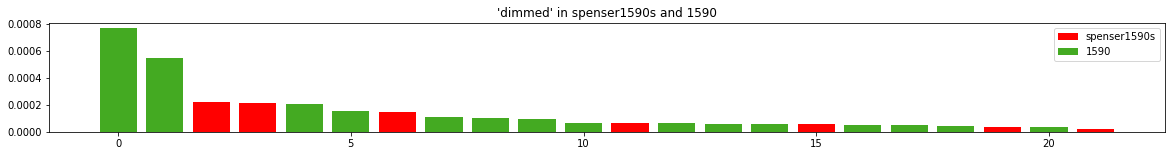

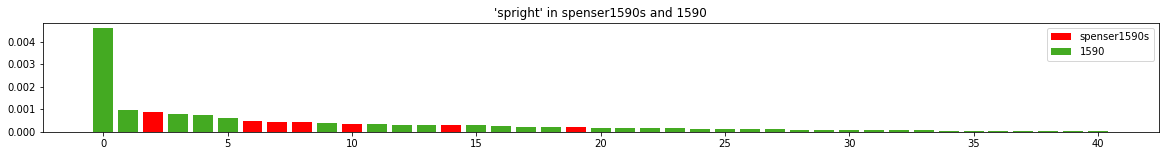

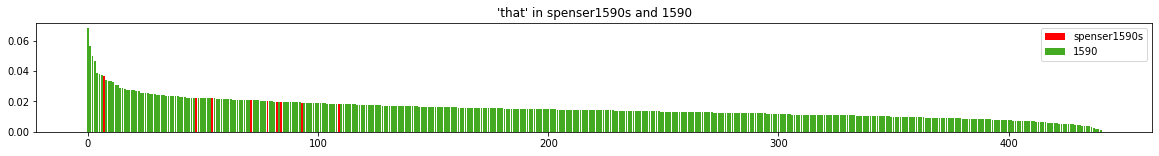

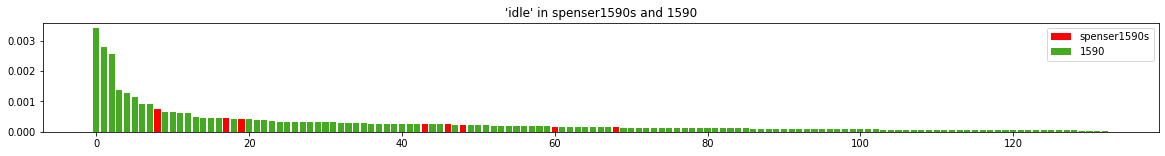

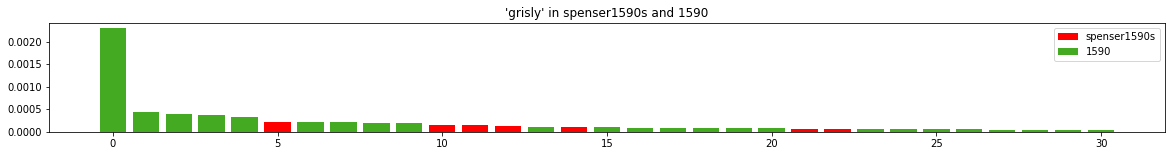

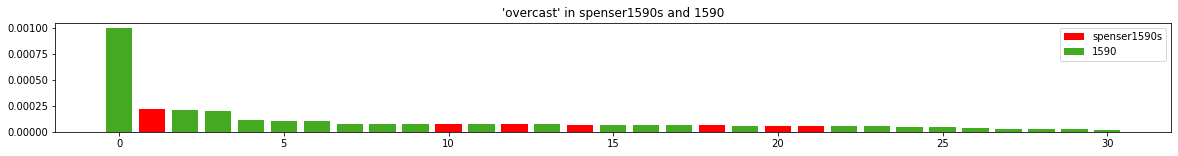

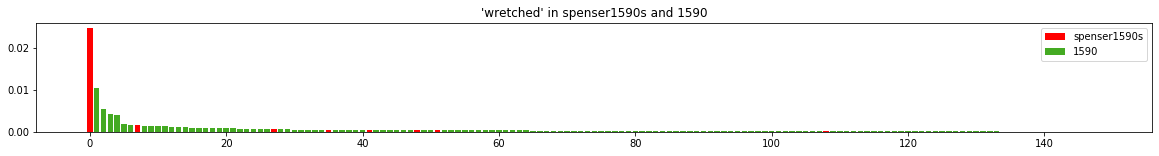

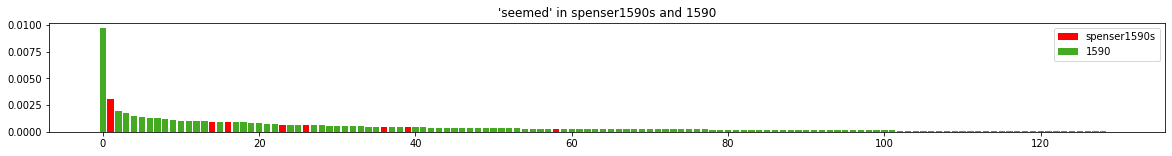

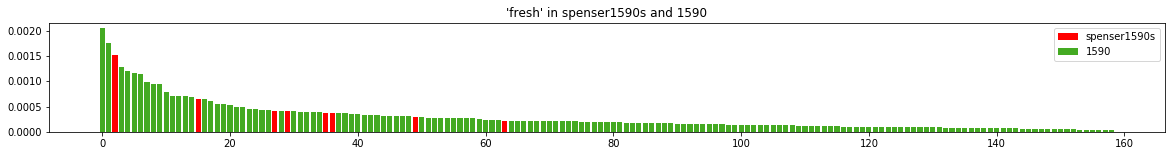

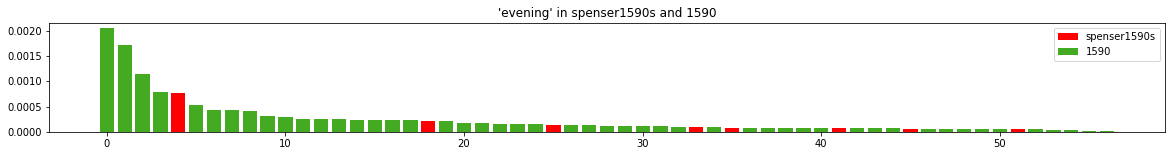

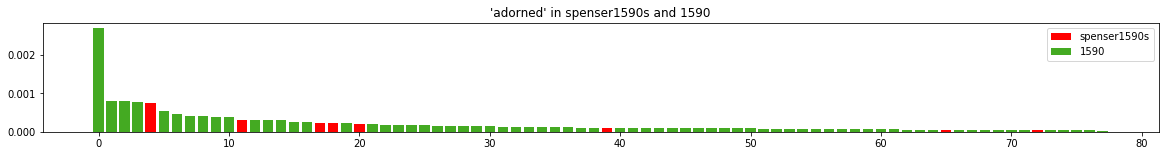

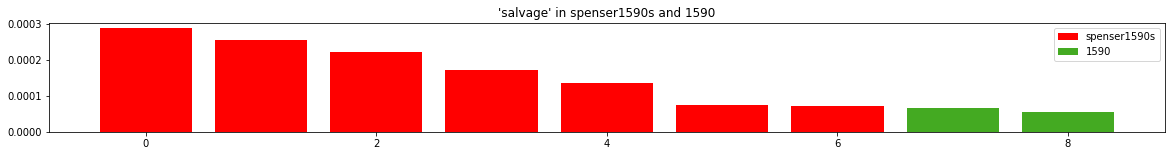

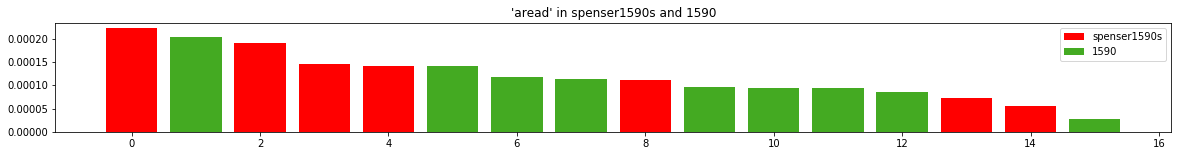

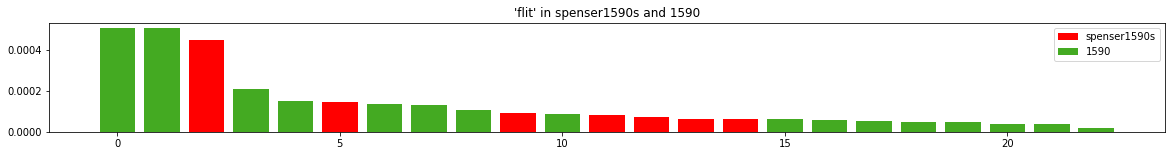

In [52]:
_ = [showterm(term, spenser1590s, verse1590, raw=False, labels=["spenser1590s", "1590"])   
     for term in ['adown','dimmed','spright','that','idle','grisly','overcast','wretched',
                  'seemed','dreadful','fresh','evening','adorned','salvage','aread','flit']]